## 강화 학습

상태(state)는 주식값에 대한 이전값, 현재 예산, 그리고 주식의 수를 나타내는 것이다.

행동(action)은 사거나, 팔거나, 아니면 그냥 가지고 있는 것을 말한다.

주식 시장 데이터는 Yahoo Finance library에서 가져오며, pip install yahoofinancials 로 설치할 수 있다.
(참조 : https://github.com/JECSand/yahoofinancials )

In [1]:
# 주식 library
from yahoofinancials import YahooFinancials

# 필요 Library
%matplotlib inline
from matplotlib import pyplot as plt 
import numpy as np
import tensorflow as tf
import random

In [2]:
#라이브러리에서 주가 호출
def get_prices(share_symbol, start_date, end_date, interval='daily'): 
    share = YahooFinancials(share_symbol)
    stock_hist = share.get_historical_price_data(start_date, end_date, interval)
    stock_prices = list()
    price_tab = stock_hist[share_symbol]['prices']
    
    for i in range(len(price_tab)):
        stock_prices.append(price_tab[i]['open'])
    stock_prices = np.array(stock_prices)
    return stock_prices.astype(float)

In [3]:
# 주식값 그래프 출력
def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    plt.savefig('prices.png')
    plt.show()

In [4]:
class DecisionPolicy:
    def select_action(self, current_state):
        pass
    
    def update_q(self, state, action, reward, next_state):
        pass

In [5]:
# 무작위 행동 선정
class RandomDecisionPolicy(DecisionPolicy):
    def __init__(self, actions):
        self.actions = actions
    
    def select_action(self, current_state, step):
        action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action

In [6]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        # Neural Network 설계시 필요한 Hyperparameter
        self.epsilon = 0.9
        self.gamma = 0.001
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 200
        
        # Neural Network 설계
        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)
        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.AdagradOptimizer(0.01).minimize(loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
 
    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            # epsilon 확률 내에서 최고의 행동을 수행함(Exploit)
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            action_idx = np.argmax(action_q_vals) 
            action = self.actions[action_idx]
        else:
            # 1 – epsilon 확률 내에서 새로운 행동을 무작위로 탐색함(Explore)
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action
    
    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        action_q_vals[0, next_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y: action_q_vals})

In [7]:
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist):
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    for i in range(len(prices) - hist - 1):
        if i % 1000 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist])
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:
            action = 'Hold'
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget,num_stocks)))
        transitions.append((current_state, action, reward, next_state))
        policy.update_q(current_state, action, reward, next_state)
    portfolio = budget + num_stocks * share_value
    return portfolio

In [9]:
def run_simulations(policy, budget, num_stocks, prices, hist):
    num_tries = 10
    final_portfolios = list()
    for _ in range(num_tries):
        final_portfolio = run_simulation(policy, budget, num_stocks, prices,hist)
        final_portfolios.append(final_portfolio)
        print('Final portfolio: ${}'.format(final_portfolio))
    plt.title('Final Portfolio Value')
    plt.xlabel('Simulation #')
    plt.ylabel('Net worth')
    plt.hlines(budget, 0, num_tries, linestyles='dashed')
    plt.plot(final_portfolios)
    plt.show()

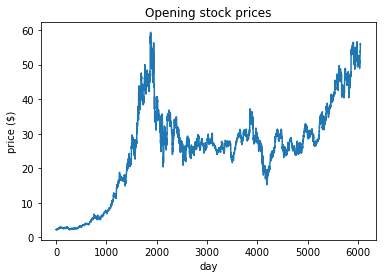

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $227077.02664661407
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $227642.20277404785
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $227440.80604076385
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $228530.6992225647
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $227601.0991754532
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $228938.4273405075
progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Fina

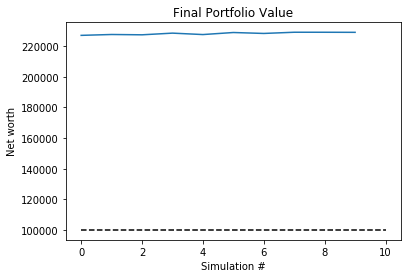

In [10]:
if __name__ == '__main__':
    prices = get_prices('MSFT', '1992-07-22', '2016-07-22')
    plot_prices(prices)
    actions = ['Buy', 'Sell', 'Hold']
    hist = 3
    #policy = RandomDecisionPolicy(actions)
    policy = QLearningDecisionPolicy(actions, hist + 2)
    budget = 100000.0
    num_stocks = 0
    run_simulations(policy, budget, num_stocks, prices, hist) 